<a href="https://colab.research.google.com/github/alessandronicolini/IncrementalLearning/blob/main/iCarl_nme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install 'import_ipynb'
!pip3 install 'tqdm'

!rm -r IncrementalLearning
# upload work files from your git hub repository
import sys

!git clone https://github.com/alessandronicolini/IncrementalLearning.git # clone proj repository
!rm -rf IncrementalLearning/README.md 
!rm -rf IncrementalLearning/baselines.ipynb

path = 'IncrementalLearning/'
if path not in sys.path:
    sys.path.append('IncrementalLearning/')

!pip3 install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=409e768154fa9a268f0e4853d600372589ecacc042efedbca0d9f66d1861eb4f
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
rm: cannot remove 'IncrementalLearning': No such file or directory
Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 797 (delta 66), reused 0 (delta 0), pack-reused 667
Receiving objects: 100% (797/797), 7.18 MiB | 5.83 MiB/s, done.
Resolving deltas: 100% (467/467), done.


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import math
from sklearn.preprocessing import normalize
import copy
import torchvision.datasets as dsets
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import Subset, DataLoader
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

import import_ipynb
from IncrementalLearning.cifar100 import ilCIFAR100

from IncrementalLearning.resnet_cifar import resnet32
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

importing Jupyter notebook from /content/IncrementalLearning/cifar100.ipynb


Extracting ./data/cifar-100-python.tar.gz to ./data
importing Jupyter notebook from /content/IncrementalLearning/resnet_cifar.ipynb


In [3]:
class icarl(nn.Module):
  def __init__(self,randomseed):
    super(icarl, self).__init__()
    self.model = resnet32(num_classes=100)
    self.feature_extractor = self.model.features
    self.lr = 2
    self.gamma = 0.2
    self.weight_decay =1e-5 
    self.milestones = [49,63]
    self.batch_size = 128
    self.numepochs = 70
    self.n_classes = 0
    self.n_known = 0
    self.feature_size=64
    self.momentum=0.9
    self.criterion=nn.BCEWithLogitsLoss()
    self.compute_means = True
    self.exemplar_means = None
    self.exemplar_sets = []
    self.exemplar_labels = []
    self.NUM_BATCHES=10
    self.randomseed=randomseed
    self.trainloader=None
    self.testloader=None
    self.CLASSES_PER_BATCH=10
    self.original_training_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed)
    self.original_test_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed, train=False)

    self.y_pred = []
    self.y_test = []

    self.classes_seen=0
    self.diz = self.original_training_set.get_dict()

  def update_parameters(self):
    old_model = copy.deepcopy(self)
    old_model.eval()
    old_model.to('cuda')
    n_classes = self.classes_seen+self.CLASSES_PER_BATCH
    print(n_classes)
    optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)
    for epoch in tqdm(range(self.numepochs)):
        
      for _, inputs, labels in self.trainloader:
        inputs = inputs.float().cuda()
        labels = torch.tensor([self.diz[c.item()] for c in labels])

        labels=labels.to('cuda')
        optimizer.zero_grad()
        outputs=self.forward(inputs)

        labels_encoded = F.one_hot(labels,100).float().cuda() #CAMBIARE ONE_HOT
        
        if self.classes_seen:
          old_target = old_model.forward(inputs).cuda()
          old_target = torch.sigmoid(old_target).cuda()
          
          target = torch.cat((old_target[:,:self.classes_seen], labels_encoded[:, self.classes_seen:]), dim=1)
          loss = self.criterion(outputs, target)
        else:
          loss = self.criterion(outputs,labels_encoded) 

        loss.backward()
        optimizer.step()
      
      scheduler.step()

  def classify_nme(self, input_batch):
    min_distances = float('inf')*torch.ones(len(input_batch)).cuda() # shape: batch_size --> 128
    y_pred = torch.zeros(len(input_batch), dtype=torch.int8).cuda() # shape: batch_size --> 128
    input_features = self.feature_extractor(input_batch) # shape: (batch_size, feature_size) --> (128, 64)

    for i in range(len(self.exemplar_sets)):
      ex_mean = self.exemplar_means[i,:]

      # compute distances between inputs features and exemplar set means
      pdist = nn.PairwiseDistance(p=2)
      distances = pdist(input_features, ex_mean) # shape: batch_size --> 128

      # update min distancies and predicted labels
      mask = distances < min_distances
      min_distances[mask] = distances[mask]
      y_pred[mask] = self.exemplar_labels[i]

    return y_pred
    

  def get_new_exemplars(self, batch, m):
    loader = torch.utils.data.DataLoader(batch, batch_size=self.batch_size,shuffle=False, num_workers=4)
    features = np.zeros((0,self.feature_size))
    indices = np.zeros((0), dtype=int)
    with torch.no_grad():
      for indexes, images, labels in loader:
        images = images.cuda()
        feature = self.feature_extractor(images).data.cpu().numpy()
        feature = normalize(feature, axis=1, norm='l2')
        features = np.concatenate((features,feature), axis=0)
        indices = np.concatenate((indices,indexes), axis=0)

    class_mean = np.mean(features, axis=0)
    class_mean = class_mean / np.linalg.norm(class_mean)  # Normalize

    exemplar_set = []
    exemplar_features = np.zeros((0,self.feature_size))

    for k in range(1, int(m)+1):
        S = np.sum(exemplar_features, axis=0)
        phi = features
        mu = class_mean
        mu_p = 1.0 / k * (phi + S)
        mu_p = normalize(mu_p, axis=1, norm='l2')
        i = np.argmin(np.sqrt(np.sum((mu - mu_p) ** 2, axis=1)))
        exemplar_set.append(indices[i])
        addfeature =  np.expand_dims(features[i], axis=0)
        exemplar_features = np.concatenate((exemplar_features,addfeature), axis=0)

        #remove duplicates
        features = np.delete(features, i, 0)
        indices = np.delete(indices, i, 0)
        
    self.exemplar_sets.append(exemplar_set)
        
  def reduce_old_exemplars(self,m):
    for y, P_y in enumerate(self.exemplar_sets):
            self.exemplar_sets[y] = P_y[:int(m)]

  def forward(self, x):
    self.model = self.model.cuda()
    return self.model.forward(x)

  def __accuracy_fc(self, dl, model, mapper):
    total = 0.0
    correct = 0.0
    for  _, images, labels in dl:
      labels = torch.tensor([torch.tensor(mapper[c.item()]) for c in labels])
      labels = labels.cuda()
      images = images.cuda()
      outputs = self.forward(images)
      _, preds = torch.max(outputs, dim=1)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

    acc = correct / total
    return acc


  def __accuracy_nme(self, dl, model, last_test=False):
    
    total = 0.0
    correct = 0.0
    
    for  _, images, labels in dl:
      labels = labels.cuda()
      images = images.cuda()
      outputs = model(images)
      preds = self.classify_nme(images)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

      if last_test:
        self.y_pred += preds.tolist()
        self.y_test += labels.tolist()

    acc = correct / total
    return acc


  def plot_confusion_matrix(self):
 
    cm = confusion_matrix(self.y_test, self.y_pred)
    cm = np.log(cm+1)
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cm, square=True, cbar=False, ax=ax, cmap=plt.get_cmap('seismic'))
    ax.set_xticks(np.linspace(19,99,5))
    ax.set_yticks(np.linspace(19,99,5))
    ax.set_xticklabels([20,40,60,80,100], rotation=0)
    ax.set_yticklabels([20,40,60,80,100], rotation=0)
    ax.set_title("iCaRL")
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    plt.savefig("iCaRL_"+str(self.randomseed)+"_cm.png")
    plt.show()
    return cm


  def training_model(self):
    
    train_indices = self.original_training_set.get_batch_indexes()
    test_indices = self.original_test_set.get_batch_indexes()
    batches=self.original_training_set.getbatches()
    current_test_indexes=[]
    test_acc = []
    last_test = False

    for i in range(self.NUM_BATCHES):

      if i == self.NUM_BATCHES-1:
        last_test = True

      for exemplars in self.exemplar_sets:
        train_indices[i]=np.concatenate([train_indices[i], np.array(exemplars)])
        #print(exemplars)

      train_dataset = Subset(self.original_training_set, train_indices[i])
      current_test_indexes += test_indices[i].tolist()
      test_dataset = Subset(self.original_test_set,current_test_indexes)

      actual_test_dataset = Subset(self.original_test_set,test_indices[i])

      self.trainloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, drop_last=True)
      self.testloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, drop_last=True) 
      self.actualtestloader = DataLoader(actual_test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, drop_last=True)

      self.train()
      self.update_parameters()    
      self.classes_seen += 10
      self.eval() # Set Network to evaluation mode

      # reduce exemplars
      m=int(2000/(int(i*10+10)))
      self.reduce_old_exemplars(m) 
      # add new exemplar sets
      for classlabel in batches[i]:
        indexes_class = self.original_training_set.get_class_indexes(classlabel)
        current_class = Subset(self.original_training_set, indexes_class)
        self.get_new_exemplars(current_class, m)
      
      # compute means of exemplar set
      # cycle for each exemplar set
      self.exemplar_means = torch.zeros((0, self.feature_size), dtype=torch.float).cuda()
      self.exemplar_labels = []
      for i in range(len(self.exemplar_sets)):
        exemplars_dataset = Subset(self.original_training_set, self.exemplar_sets[i])
        exemplars_loader = torch.utils.data.DataLoader(exemplars_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
        ex_features = torch.zeros((0, self.feature_size), dtype=torch.float).cuda() # alla fine shape: (len(exemplar_set), feature_size) --> (m, 64)
      
        with torch.no_grad():
          _, _, exemplar_label = self.original_training_set.__getitem__(self.exemplar_sets[i][0]) 
          self.exemplar_labels.append(exemplar_label)
          # cycle for each batch in the current exemplar set
          for _,  exemplars, _ in exemplars_loader:
          
            # get exemplars features
            exemplars = exemplars.cuda()
            features = self.feature_extractor(exemplars) # shape: (len(exemplars), feature_size)
          
            # normalize 
            feature_norms = torch.norm(features, p=2, dim=1) # shape: len(exemplars)
            feature_norms.unsqueeze_(1) # shape: (len(exemplars), 1)
            features = features/feature_norms
          
            # concatenate over columns
            ex_features = torch.cat((ex_features, features), dim=0)
          
        # compute current exemplar set mean and normalize it
        ex_mean = torch.mean(ex_features, dim=0) # shape: feature_size --> 64
        ex_mean = ex_mean/torch.norm(ex_mean)
        ex_mean.unsqueeze_(0) # shape: (1, feature_size) --> (1, 64)
        self.exemplar_means = torch.cat((self.exemplar_means, ex_mean), dim=0) # shape: (n_examplar set, feature size)
      

      print('accuracy on training set:', 100*self.__accuracy_fc(self.trainloader,self,self.diz))
      # print('accuracy on test set:', self.__accuracy_on(self.testloader,self,self.diz))
      current_test_acc = self.__accuracy_nme(self.testloader, self, last_test)
      print('accuracy on test set:', 100*current_test_acc)
      print('accuracy on actual test set: ', 100*self.__accuracy_nme(self.actualtestloader, self))
      print('-' * 80)
      test_acc.append(current_test_acc)

    # compute comfusion matrix and save results
    cm = self.plot_confusion_matrix()
    with open('iCaRL_'+str(self.randomseed)+"_cm", 'wb') as file:
      pickle.dump(cm, file, protocol=pickle.HIGHEST_PROTOCOL)
    with open('iCaRL_'+str(self.randomseed)+"_testacc", 'wb') as file:
      pickle.dump(test_acc, file, protocol=pickle.HIGHEST_PROTOCOL)


Files already downloaded and verified
Files already downloaded and verified
10



accuracy on training set: 99.0985576923077
accuracy on test set: 84.70982142857143
accuracy on actual test set:  85.04464285714286
--------------------------------------------------------------------------------
20



accuracy on training set: 90.97222222222221
accuracy on test set: 70.78125
accuracy on actual test set:  67.29910714285714
--------------------------------------------------------------------------------
30



accuracy on training set: 89.98842592592592
accuracy on test set: 66.16847826086956
accuracy on actual test set:  68.41517857142857
--------------------------------------------------------------------------------
40



accuracy on training set: 90.6105324074074
accuracy on test set: 62.77721774193549
accuracy on actual test set:  68.75
--------------------------------------------------------------------------------
50



accuracy on training set: 89.61226851851852
accuracy on test set: 59.01442307692307
accuracy on actual test set:  62.38839285714286
--------------------------------------------------------------------------------
60



accuracy on training set: 90.07523148148148
accuracy on test set: 56.5047554347826
accuracy on actual test set:  62.83482142857143
--------------------------------------------------------------------------------
70



accuracy on training set: 90.58159722222221
accuracy on test set: 53.09606481481482
accuracy on actual test set:  61.16071428571429
--------------------------------------------------------------------------------
80



accuracy on training set: 89.27951388888889
accuracy on test set: 51.197076612903224
accuracy on actual test set:  59.48660714285714
--------------------------------------------------------------------------------
90



accuracy on training set: 89.19270833333334
accuracy on test set: 48.738839285714285
accuracy on actual test set:  59.48660714285714
--------------------------------------------------------------------------------
100



accuracy on training set: 88.13657407407408
accuracy on test set: 46.30408653846153
accuracy on actual test set:  54.01785714285714
--------------------------------------------------------------------------------


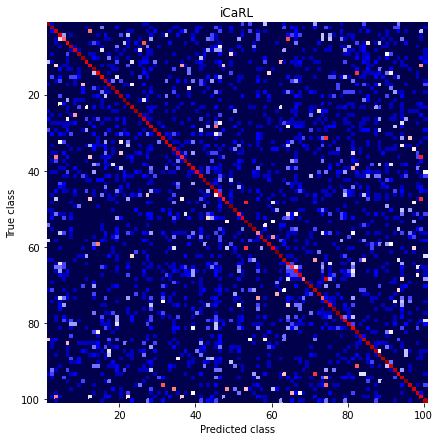

In [5]:
model = icarl(randomseed=7).cuda()
model.training_model()